In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [5]:
(train_dataset.data.shape[0] // 128) * 128

12288

In [6]:
train_dataset.data = train_dataset.data[:(train_dataset.data.shape[0] // 128) * 128,]
train_dataset.targets = train_dataset.targets[:(train_dataset.data.shape[0] // 128) * 128]

In [7]:
test_dataset.data = test_dataset.data[:(test_dataset.data.shape[0] // 128) * 128,]
test_dataset.targets = test_dataset.targets[:(test_dataset.data.shape[0] // 128) * 128]

In [8]:
train_dataset.targets.shape

torch.Size([12288])

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [9]:
train_dataset

Dataset MNIST
    Number of datapoints: 12288
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 1920
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [11]:
12396 / 2 ** 2

3099.0

In [12]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

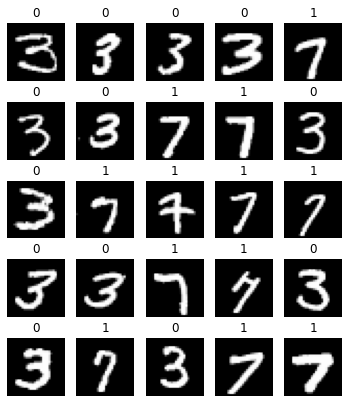

In [13]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [14]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [15]:
x.shape

torch.Size([128, 1, 28, 28])

In [16]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [17]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [18]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [19]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [20]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [21]:
y

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1], dtype=int64)

# Итерация по эпохам

In [22]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация
        
        time.sleep(0.01)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [23]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.27651292, 0.35321675, 0.05123134, ..., 0.71139888, 0.48502518,
        0.79018237],
       [0.17218684, 0.83374249, 0.08324745, ..., 0.44878908, 0.59879483,
        0.26145643],
       [0.77571291, 0.68345396, 0.2920336 , ..., 0.16361136, 0.86949834,
        0.62498626],
       ...,
       [0.95884375, 0.48023171, 0.216986  , ..., 0.98572489, 0.64693488,
        0.54103537],
       [0.16695108, 0.69319187, 0.08263194, ..., 0.82094937, 0.90957066,
        0.8023221 ],
       [0.17065894, 0.38935949, 0.90700508, ..., 0.20897358, 0.90948265,
        0.67492205]])

In [24]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы 
x ** 2 + np.log(x)

array([[-1.20903832, -0.91591131, -2.96877917, ...,  0.16556637,
        -0.48830505,  0.38889667],
       [-1.7295268 ,  0.51329585, -2.47900766, ..., -0.59979063,
        -0.15428101, -1.27312815],
       [ 0.34775772,  0.08651334, -1.14560278, ..., -1.78349275,
         0.61618852, -0.07941779],
       ...,
       [ 0.8773542 , -0.50286408, -1.48083953, ...,  0.95727558,
        -0.0169849 , -0.32155135],
       [-1.76218176,  0.11406652, -2.48653098, ...,  0.47666402,
         0.73253618,  0.42347561],
       [-1.73896373, -0.7916514 ,  0.72505098, ..., -1.52187747,
         0.73227935,  0.06236171]])

In [25]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [26]:
res

array([[124.32364808, 131.35949763, 131.66399233, ..., 123.45888106,
        126.66448524, 125.85200503],
       [123.92255051, 134.08725491, 135.97115802, ..., 127.52282509,
        128.22902168, 130.85795939],
       [119.29848862, 125.91230979, 126.12915974, ..., 119.29737242,
        118.74322872, 123.29532861],
       ...,
       [123.89285731, 135.50313972, 134.37182854, ..., 126.38481335,
        130.25760436, 126.97275257],
       [126.55262776, 133.28907244, 133.98794881, ..., 131.58991594,
        132.34512514, 131.46894339],
       [123.1322233 , 128.34294958, 132.72147223, ..., 126.7323831 ,
        126.54810677, 133.06944246]])

In [27]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [28]:
from our_library import layers, wrapper, tools

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Пример c сигмоидой
В `our_library.layers` также это есть

In [29]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):
        self._sigmoid_result = 1 / (1 + np.exp(-x))
        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """
        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad
        return new_grad

    def step(self, learning_step):
        pass

# Тестирование

In [30]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [31]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [32]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [33]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

In [34]:
forward_result

array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
       [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

# Линейный слой

In [35]:
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.random.rand(out_features) * 0.01
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x):
        self.x = x
        self._x = np.dot(x, self.weight) + self.bias
        return self._x

    def backward(self, grad):
        self._grad_weight = np.dot(self.x.T, grad)
        self._grad_bias = np.dot(np.ones((self.x.shape[0])), grad)
        grad_x = np.dot(grad, self.weight.T)
        return grad_x

    def step(self, learning_rate):
        self.weight -= learning_rate * self._grad_weight
        self.bias -= learning_rate * self._grad_bias

# Тестирование

In [36]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [37]:
linear = Linear(in_features=4, out_features=3)

# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [38]:
forward = linear.forward(x)
backward = linear.backward(previous_grad)

In [39]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [40]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

In [41]:
# значения должны быть близкими
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [42]:
# значения должны быть близкими
assert np.allclose(linear._grad_bias, correct_grad_bias)

# ReLU

In [43]:
class ReLU:

    def __init__(self):
        self._relu_result = None

    def forward(self, x):
        self._relu_result = np.where(x > 0, x, 0)
        return self._relu_result

    def backward(self, prev_grad):
        return np.where(self._relu_result > 0, 1, 0) * prev_grad

    def step(self, learning_rate):
        ...

# Тестирование

In [44]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [45]:
relu = ReLU()

In [46]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [47]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [48]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [49]:
class BCELoss:

    def __init__(self):
        self.grad = None

    def forward(self, x, y):
        self.x = x
        y = np.expand_dims(y, 1)
        self.y = y
        self._bce_res = - np.mean(y * np.log(x) + (1 - y) * np.log(1 - x))
        return self._bce_res

    def backward(self):
        self.grad = ((1 - self.y) / (1 - self.x) - self.y / self.x) / self.x.shape[0]
        return self.grad
        
    def step(self, learning_rate):
        ...

# Тестирование

In [50]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [51]:
loss = BCELoss()

In [52]:
forward = loss.forward(x, y)
backward = loss.backward()

In [53]:
forward

0.24384403491500606

In [54]:
backward

array([[-0.32790194],
       [ 0.27497946],
       [-0.41544356],
       [ 0.27656947]])

In [55]:
# значения должны быть близкими
# assert np.allclose(correct_forward_result, forward)

In [56]:
# значения должны быть близкими
# assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [57]:
class NeuralNetwork:

    def __init__(self, modules):
        self.modules = modules

    def forward(self, x):
        in_ = x
        for module in self.modules:
            out = module.forward(in_)
            in_ = out
        return out

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for module in self.modules[::-1]:
            grad = module.backward(grad)

    def step(self, learning_rate):
        [module.step(learning_rate) for module in self.modules if module]

## Реализуйте обертку над моделью

In [58]:
from importlib import reload
import our_library
reload(our_library)

from our_library import layers, wrapper, tools


class MNISTWrapper(wrapper.Wrapper):

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        probs = self.model.forward(x)
        loss = self.loss.forward(probs[:, :1], y)
        grad = self.loss.backward()
        self.model.backward(grad)
        self.model.step(self.learning_rate)
        return loss, probs[:, 1]

In [70]:
# задайте гиперпараметры
learning_rate = 5e-2
epochs = 20

linear_1 = Linear(in_features=784, out_features=400)
linear_2 = Linear(in_features=400, out_features=20)
linear_3 = Linear(in_features=20, out_features=2)
sigmoid_layer = Sigmoid()
relu1 = ReLU()
relu2 = ReLU()

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([linear_1, relu1, linear_2, relu2, linear_3, sigmoid_layer])

loss = BCELoss()

In [71]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate,
                          multi_class=False)

## Обучение модели

In [72]:
classifier.train(train_loader, test_loader, epochs=epochs)

Epoch 20: 100%|██████████| 96/96 [00:06<00:00, 14.96it/s, loss=0.0225, metric=0.997]


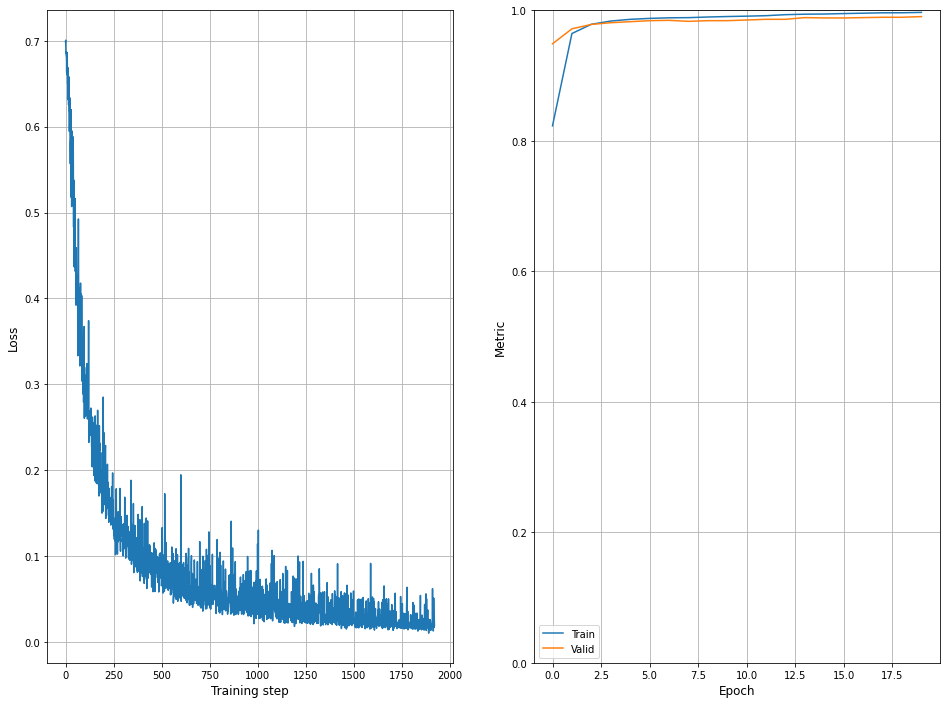

In [62]:
classifier.plot()